In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import numba
from PIL import Image

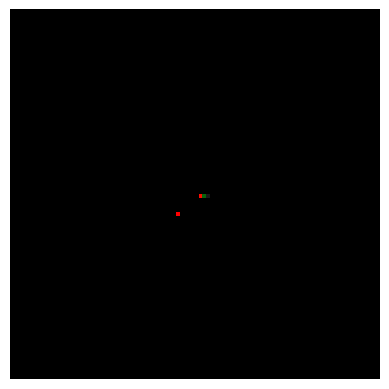

In [9]:
class Canvas():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.pixels = np.zeros((y,x,3),dtype=int)

    def _center2pixel(self, x, y):
        return (self.y//2 - y, self.x//2 + x)

    def write_pixel(self, x, y, color):
        x,y = self._center2pixel(x,y)
        self.pixels[x,y] = color.astype(int)

    def show(self):
        plt.imshow(self.pixels, vmin=0, vmax=255)
        plt.gca().axis('off')
        plt.show()

    
canvas = Canvas(100,100)


canvas.write_pixel(-5,-5,np.array([255,0,0]))
canvas.write_pixel(1,0,np.array([255,10,0]))
canvas.write_pixel(2,0,np.array([10,100,10]))
canvas.write_pixel(3,0,np.array([25.5,25.5,25.5]))
canvas.show()

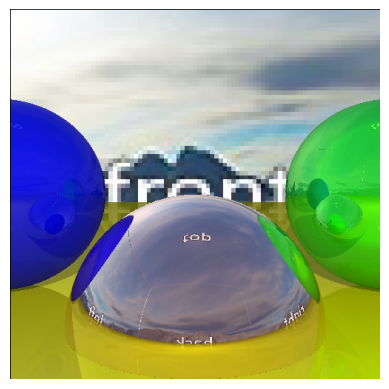

In [117]:
class Camera():
    def __init__(self, position=(0,0,0), orientation=[[1,0,0],[0,1,0],[0,0,1]], d=1, w=1, h=1, resolution=(100,100)):
        self.position = np.array(position)
        self.orientation = np.array(orientation)
        # distance from camera to canvas
        self.d = d

        # width and height of camera frame otherwise known as the FoV
        self.w = w
        self.h = h

        self.resolution = resolution

        if not resolution[1]/self.resolution[0] == h/w:
            raise "Resolution does not match aspect ratio"

        
        self.canvas = Canvas(*resolution)

    def canvas_to_world(self, x, y):
        return (x*self.w/self.resolution[0], y*self.h/self.resolution[1], self.d)

class Ray():
    def __init__(self, origin, direction, tmin=1, tmax=np.inf):
        self.origin = np.array(origin)
        self.direction = np.array(direction)

        self.tmin = tmin
        self.tmax = tmax

    def p(self, t):
        return self.origin + t*self.direction
    
class PointLight():
    def __init__(self, position, intensity):
        self.position = np.array(position)
        self.intensity = intensity

    def get_L(self, P):
        return self.position - P
        

class DirectionalLight():
    def __init__(self, position, direction, intensity):
        self.position = np.array(position)
        self.direction = np.array(direction)
        self.intensity = intensity
    
    def get_L(self, P):
        return self.direction


class BasicMaterial():
    def __init__(self, color, ambient=0.4, specular=0.9, reflective=0.2):
        self.color = np.array(color)
        self.ambient = ambient
        self.specular = specular
        self.reflective = reflective


class Sphere():
    def __init__(self, position=(0,0,5), radius=1, material=BasicMaterial((255,255,255))):
        self.position = np.array(position)
        self.radius = np.array(radius)
        self.material = material

    def intersect(self, ray):
        a = np.dot(ray.direction, ray.direction)
        b = 2*np.dot(ray.origin-self.position, ray.direction)
        c = np.dot(ray.origin-self.position, ray.origin-self.position) - self.radius**2

        discriminant = b**2 - 4*a*c

        if discriminant < 0:
            return [np.inf]
        else:
            t1 = (-b - np.sqrt(discriminant))/(2*a)
            t2 = (-b + np.sqrt(discriminant))/(2*a)
            return [t1,t2]

    def normal(self, point):
        # return normalized normal vector. 
        return (point-self.position)/self.radius



def closest_intersection(ray, objects):
    closest_object = None
    closest_t = np.inf
    for obj in objects:
        ts = obj.intersect(ray)
        for t in ts:
            if ray.tmin<=t<=ray.tmax:
                if t<closest_t:
                    closest_object = obj
                    closest_t = t
    return closest_object, closest_t


def split_cubemap(image):
    height, total_width, _ = image.shape
    face_width = total_width // 4

    images = [
              image[face_width:2*face_width, 2*face_width:3*face_width], # POSITIVE X
              image[face_width:2*face_width, 0:face_width], # NEGATIVE X
              image[0:face_width, face_width:2*face_width], # POSITIVE Y
              image[2*face_width:3*face_width, face_width:2*face_width], # NEGATIVE Y
              image[face_width:2*face_width, face_width:2*face_width], # POSITIVE Z
              image[face_width:2*face_width, 3*face_width:4*face_width], # NEGATIVE Z
            ]
    
    return images




class SkyBox():
    def __init__(self, image):
        self.image = np.array(image)

        self.images = split_cubemap(self.image)
    
    def sphere2pixel(self, P):
        x,y,z = P
        abs_x, abs_y, abs_z = np.abs(P)

        x_positive = x>0
        y_positive = y>0
        z_positive = z>0

        # POSITIVE X
        if x_positive and abs_x >= abs_y and abs_x >= abs_z:
            max_axis = abs_x
            uc = -z
            vc = y
            index = 0

        # NEGATIVE X
        if not x_positive and abs_x >= abs_y and abs_x >= abs_z:
            max_axis = abs_x
            uc = z
            vc = y
            index = 1
        
        # POSITIVE Y
        if y_positive and abs_y >= abs_x and abs_y >= abs_z:
            max_axis = abs_y
            uc = x
            vc = -z
            index = 2
        
        # NEGATIVE Y
        if not y_positive and abs_y >= abs_x and abs_y >= abs_z:
            max_axis = abs_y
            uc = x
            vc = z
            index = 3

        # POSITIVE Z
        if z_positive and abs_z >= abs_x and abs_z >= abs_y:
            max_axis = abs_z
            uc = x
            vc = y
            index = 4
        
        # NEGATIVE Z
        if not z_positive and abs_z >= abs_x and abs_z >= abs_y:
            max_axis = abs_z
            uc = -x
            vc = y
            index = 5

        # convert from (-1,1) to (0,1)
        u = 0.5 * (uc / max_axis + 1)
        v = 0.5 * (vc / max_axis + 1)

        pixel = [v,u]
        pixel = (int(self.images[index].shape[0]-pixel[0]*self.images[index].shape[0]), 
                    int(pixel[1]*self.images[index].shape[1])-1)

        return pixel[0], pixel[1], index

    def get_color(self, P):
        x,y, index = self.sphere2pixel(P)
        return self.images[index][x,y]





class Scene():
    def __init__(self, camera, objects=[], lights=[], skybox=None):
        self.camera = camera
        self.objects = objects
        self.lights = lights
        self.skybox = skybox

    def is_in_shadow(self, P, light, closest_object):
        L = light.get_L(P)
        ray = Ray(P, L, tmin=0.001, tmax=np.inf)

        closest_object, closest_t = closest_intersection(ray, self.objects)
        
        if closest_object is None:
            shadow = False
        else:
            shadow = True

        return shadow

    def illuminate(self, light, P, N, V, material, shadow):
        L = light.get_L(P)
        N_dot_L = np.dot(N, L)
        
        I = 0

        if shadow:
            return I

        # diffuse
        if N_dot_L>0:
            I+= light.intensity * N_dot_L/(np.linalg.norm(L)*np.linalg.norm(N))

        # specular
        if material.specular != 0:
            R = 2*N_dot_L*N - L
            R_dot_V = np.dot(R, V)
            if R_dot_V>0:
                I+= light.intensity * np.power(R_dot_V/(np.linalg.norm(R)*np.linalg.norm(V)), material.specular)

        return I


    def compute_lighting(self, P, N, V, object):
        intensity = object.material.ambient
        for light in self.lights:
            shadow = self.is_in_shadow(P, light, object)
            intensity += self.illuminate(light, P, N, V, object.material, shadow)
        
        intensity = np.min([intensity, 1])
        return object.material.color*intensity
        
    def trace_ray(self, ray, objects, lights, depth=1, max_depth=5):
        closest_object, closest_t = closest_intersection(ray, objects)

        if closest_object is None:
            # handle skybox 
            if self.skybox:
                camera_pos = self.camera.position
                sphere = Sphere(camera_pos, 1000, BasicMaterial([0,0,0]))
                closest_object, closest_t = closest_intersection(ray, [sphere]) 
                return self.skybox.get_color(ray.p(closest_t) - camera_pos)
            else:
                return np.array([0,0,0])
            
            
        intensity = 0
        P = ray.p(closest_t)
        N = closest_object.normal(P)
        V = -ray.direction
        
        local_color = self.compute_lighting(P, N, V, closest_object)

        r = closest_object.material.reflective
        if r == 0 or depth >= max_depth:
            return local_color

        R = ray.direction - 2*np.dot(ray.direction, N)*N
        reflected_color = self.trace_ray(Ray(P, R, tmin=0.001, tmax=np.inf), objects, lights, depth+1, max_depth)

        return local_color * (1- r) + r * reflected_color



    def render(self):

        for x in range(-self.camera.resolution[0]//2+1, self.camera.resolution[0]//2):
            for y in range(-self.camera.resolution[1]//2+1, self.camera.resolution[1]//2):
                D = self.camera.orientation@self.camera.canvas_to_world(x,y)
                ray = Ray(self.camera.position, D, tmin=self.camera.d, tmax=np.inf)
                color = self.trace_ray(ray, self.objects, self.lights)
                self.camera.canvas.write_pixel(x,y, color)


        return self.camera.canvas


alpha = 0.1
camera = Camera(resolution=(500,500), position=[0,0, 0], orientation=[[1,0,0],[0,1,0],[0,0,1]])
spheres = [Sphere(position=(0,-1,3), radius=1,  material=BasicMaterial((255,0,0), specular=10, reflective=0.9, ambient=0.4)), 
           Sphere(position=(-2,0,4),  radius=1, material=BasicMaterial((0,0,255), reflective=0.2, specular=500)),
           Sphere(position=(2,0,4), radius=1,   material=BasicMaterial((0,255,0), reflective=0.4)),
           Sphere(position=(0,-5001,0), radius=5000, material=BasicMaterial((255,255,0), specular=1000)),
           ]

# image = Image.open('image21.png')
# image = Image.open('miramar.jpeg')
image = Image.open("cubemaps_skybox.jpeg")
skybox = SkyBox(image)


lights = [PointLight(position=(0,1,0), intensity=0.6)]
scene = Scene(camera, spheres, lights, skybox)
scene.render().show()